In [115]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder

import os
import shutil
from PIL import Image
import time

In [9]:
device = "device" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
# data splitting
os.makedirs("data/train/0")
os.makedirs("data/train/1")
os.makedirs("data/test/test")

In [11]:
train_data = pd.read_csv("Train.csv")
train_data.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [12]:
files = []
for (root, dirs, file ) in os.walk("data"):
    files += file

In [13]:
# copy to data
image_ids = train_data["Image_id"].values
for i in range(len(files)):
    if files[i] in image_ids:
        shutil.copy("data/"+files[i], "data/train/"+str(train_data.loc[train_data["Image_id"] == files[i]]["Label"].values[0]))

In [14]:
test_data = pd.read_csv("Test.csv")
# copy to data
image_ids_test = test_data["Image_id"].values
for i in range(len(files)):
    if files[i] in image_ids_test:
        shutil.copy("data/"+files[i], "data/test/test")

In [139]:
# preprocessing
transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data sets
trainset = ImageFolder("data/train/", transform=transform)
testset = ImageFolder("data/test/", transform=transform)

# data loading
trainloader = DataLoader(trainset, shuffle=True, batch_size=32)
testloader = DataLoader(testset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


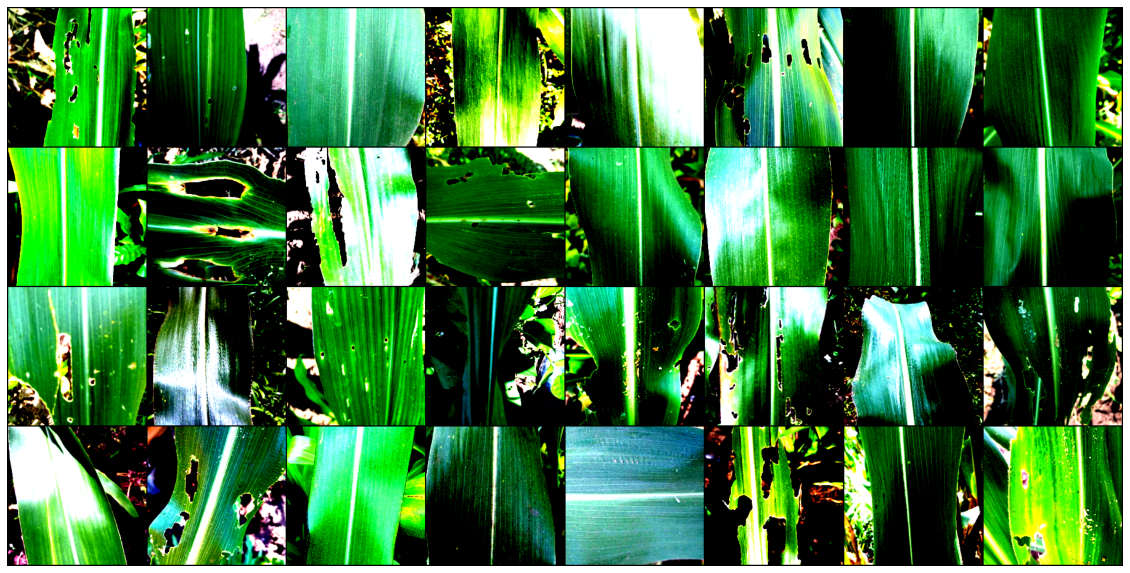

tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1])


In [140]:
# data visualization
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(20, 20))
plt.axis('off')
imshow(torchvision.utils.make_grid(images))
print(labels)

In [185]:
# ML Process
# 1. Model Definition
class ArmyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # cnn
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # pooling
        self.pool = nn.MaxPool2d((2,2))
        # linear
        self.fc1 = nn.Linear(32*53*53, 1024)
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = ArmyNet()
model.to(device)

ArmyNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [186]:
# 2. Hyperparameter Definition
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [187]:
# 3. Model Training
def train(model, epochs, trainloader, criterion, optimizer):
    for epoch in range(epochs):
        start = time.time()
        running_loss = 0.0
        correct = 0.0
        
        model.train()
        for batch, (data, labels) in enumerate(trainloader):
            data, labels = data.to(device), labels.to(device)
            
            # optimizer
            optimizer.zero_grad()
            # output
            output = model.forward(data)
            # loss
            loss = criterion(output, labels)
            running_loss += loss.item()
            # back propagation and update
            loss.backward()
            optimizer.step()
            # calculate accuracy
            _, preds = torch.max(output, 1)
            correct += torch.sum(preds == labels.data).item()
            
        stop = time.time()
        # logging
        accuracy = 100*(correct/len(trainloader.dataset))
        print(f"Epoch: {epoch+1}, Train Loss: {running_loss/len(trainloader.dataset):.4f}, Train Accuracy: {accuracy:.4f}, Time: {stop-start} s")
        running_loss = 0.0

In [188]:
# train
train(model, 10, trainloader, criterion, optimizer)

Epoch: 1, Train Loss: 0.0198, Train Accuracy: 65.3490, Time: 120.0458710193634 s
Epoch: 2, Train Loss: 0.0167, Train Accuracy: 72.3286, Time: 121.73277473449707 s
Epoch: 3, Train Loss: 0.0149, Train Accuracy: 77.7641, Time: 119.92541289329529 s
Epoch: 4, Train Loss: 0.0132, Train Accuracy: 82.1495, Time: 142.94443154335022 s
Epoch: 5, Train Loss: 0.0120, Train Accuracy: 82.0259, Time: 159.39706301689148 s
Epoch: 6, Train Loss: 0.0102, Train Accuracy: 85.9790, Time: 124.52451586723328 s
Epoch: 7, Train Loss: 0.0093, Train Accuracy: 87.2761, Time: 122.68960618972778 s
Epoch: 8, Train Loss: 0.0088, Train Accuracy: 89.3762, Time: 140.37867951393127 s
Epoch: 9, Train Loss: 0.0075, Train Accuracy: 90.7350, Time: 128.21294379234314 s
Epoch: 10, Train Loss: 0.0067, Train Accuracy: 91.7233, Time: 122.40088701248169 s


In [189]:
# save model weights
torch.save(model.state_dict(), "model.pt")

In [190]:
# load model weights
model = ArmyNet()
model.load_state_dict(torch.load("model.pt"))
model.to(device)

ArmyNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [191]:
# 4. Model Evaluation
def test(model, testloader):
    model.eval()
    test_loss = 0.0
    # correct = 0.0
    
    for batch, (data, labels) in enumerate(testloader):
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        loss = criterion(output, labels)
        test_loss += loss.item()
        
        # calculate accuracy
        # _, preds = torch.max(output, 1)
        # correct += torch.sum(preds == labels.data).item()
        
    # logging
    # accuracy = 100*(correct/len(testloader.dataset))
    print(f"Test Loss: {test_loss/len(testloader.dataset):.4f}") #, Test Accuracy: {accuracy:.4f}")

In [192]:
# evaluate
test(model, testloader)

Test Loss: 0.0376


In [193]:
# submission
submission = pd.read_csv("SampleSubmission.csv")
submission.head()

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0
1,id_03dqinf6w0znv.jpg,0
2,id_046yl0cxn3ybz.jpg,0
3,id_04athdtx2abyg.jpg,0
4,id_062aauf9e9jk0.jpg,0


In [194]:
for id in submission["Image_id"]:
    image = Image.open(f"data//test//test\\{id}")
    image_t = transform(image).unsqueeze(0)
    # print(model.forward(image_t))
    submission.loc[submission["Image_id"] == id, "Label"] = torch.argmax(model.forward(image_t)).item()

In [195]:
submission.to_csv("submission.csv", index=False)